MORDM OPTIMIZATION

In [8]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging, MultiprocessingEvaluator, Scenario, HypervolumeMetric
from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress, to_problem)

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [9]:
model, planning_steps = get_model_for_problem_formulation(2)

#The model requires a reference scenario to "kick-start"
reference_scenario = Scenario('reference', **{
    'discount rate 0': 1.5,
    'discount rate 1': 1.5,
    'discount rate 2': 1.5,
    'A.0_ID flood wave shape': 75,
    'A.1_Bmax': 240,
    'A.1_pfail': 0.25,
    'A.1_Brate': 10,
    'A.2_Bmax': 240,
    'A.2_pfail': 0.25,
    'A.2_Brate': 10,
    'A.3_Bmax': 240,
    'A.3_pfail': 0.25,
    'A.3_Brate': 10,
    'A.4_Bmax': 240,
    'A.4_pfail': 0.25,
    'A.4_Brate': 10,
    'A.5_Bmax': 240,
    'A.5_pfail': 0.25,
    'A.5_Brate': 10
})

In [10]:
convergence_metrics = [EpsilonProgress()]
nfe = 1000
epsilon = [0.5,0.5,0.5,0.01,0.01]
# Each epsilon value corresponds to a model outcome. The model outcomes are:
# expected damages, dike investment costs, rfr costs, evacuation cost, and casualties
# We select higher epsilon values to damages and costs, while we choose lower values for evacuation costs and casualties.

In [11]:
with MultiprocessingEvaluator(model) as evaluator:
    optimization_result = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=epsilon,  convergence=convergence_metrics,reference=reference_scenario)

[MainProcess/INFO] pool started with 8 workers
1098it [02:04,  8.83it/s]                                                      
[MainProcess/INFO] optimization completed, found 91 solutions
[MainProcess/INFO] terminating pool


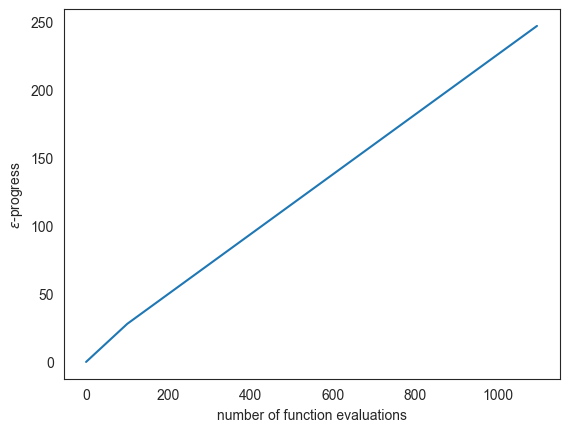

In [14]:
import matplotlib.pyplot as plt
import numpy as np
result, convergence = optimization_result
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

In [15]:
from ema_workbench import save_results
#save_results(total, 'MORDM_100k_ep0.25.tar.gz'.format(nfe))

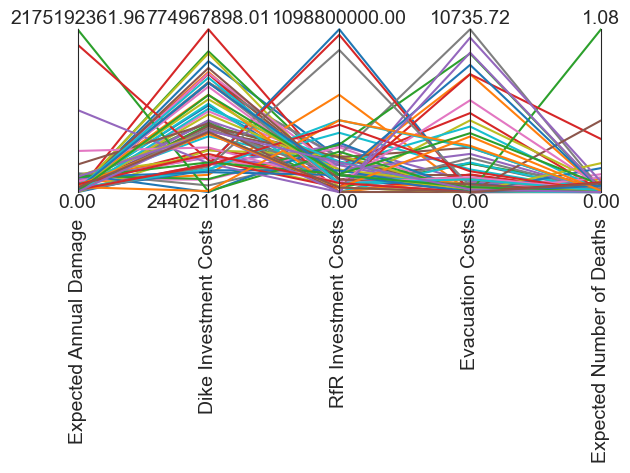

In [16]:
from ema_workbench.analysis import parcoords

data = result.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [18]:
# Select only those policies that result in an acceptable # of deaths
archive_allowable_deaths = result[result['Expected Number of Deaths'] < 0.001]
archive_allowable_deaths

    0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1   
0         1        1        0        0        0        0        0        1  \
2         0        0        1        0        0        0        0        1   
3         0        0        1        0        0        0        0        0   
7         0        0        1        0        0        0        1        0   
20        0        1        1        0        0        1        1        1   
21        0        0        1        0        0        0        0        1   
23        0        0        0        0        0        0        0        0   
24        0        0        0        0        0        0        0        1   
28        0        0        0        1        0        0        0        0   
38        0        0        0        0        0        0        0        0   
39        0        0        1        0        0        0        0        0   
62        0        1        0        0        0        0        

In [20]:
# Remove columns for outcomes from the dataframe, resulting in a df of polcies
policies = archive_allowable_deaths.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,1,1,0,0,0,0,0,1,1,0,...,7,8,7,2,7,4,5,8,7,10
2,0,0,1,0,0,0,0,1,0,0,...,9,4,7,6,10,7,6,5,9,5
3,0,0,1,0,0,0,0,0,0,0,...,1,5,7,5,5,5,5,5,1,9
7,0,0,1,0,0,0,1,0,0,0,...,0,5,6,6,5,5,5,7,0,9
20,0,1,1,0,0,1,1,1,1,1,...,0,2,5,0,2,9,2,3,0,0
21,0,0,1,0,0,0,0,1,0,0,...,5,5,3,4,6,5,6,5,0,1
23,0,0,0,0,0,0,0,0,0,0,...,7,10,5,1,1,2,5,8,7,5
24,0,0,0,0,0,0,0,1,1,0,...,5,6,2,3,6,7,7,4,3,2
28,0,0,0,1,0,0,0,0,1,0,...,0,6,5,5,7,5,1,7,3,0
38,0,0,0,0,0,0,0,0,1,0,...,5,6,4,2,7,5,6,3,5,2


In [ ]:
convergence_metrics = [
    ArchiveLogger(
        "./MORDM_Data",
        [l.name for l in model.levers],
        [o.name for o in model.outcomes],
        base_filename="MORDM_HV_1.tar.gz",
    ),
    EpsilonProgress(),
]

with MultiprocessingEvaluator(model) as evaluator:
    results, convergence = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=epsilon,  convergence=convergence_metrics,reference=reference_scenario)

In [ ]:
archives = ArchiveLogger.load_archives("./MORDM_Data/MORDM_HV_1.tar.gz")

In [ ]:
reference_set = results
problem = to_problem(model, searchover="levers")

hv = HypervolumeMetric(reference_set, problem)

hypervolume = [(nfe, hv.calculate(archive)) for nfe, archive in archives.items()]
hypervolume.sort(key=lambda x:x[0])
hypervolume = np.asarray(hypervolume)

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
ax2.set_ylim(ymin=0)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [ ]:
from ema_workbench.analysis import parcoords

data = result.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

Filtering the found solutions to those that are most important for the Delta Commission.

In [ ]:
from ema_workbench.analysis import parcoords

data = archive_allowable_deaths.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()